In [32]:
from __future__ import print_function, division   # Ensures Python3 printing & division standard
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
import seaborn as sns
sns.set_theme()

# ML
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
import xgboost as xgb
import shap # shap values
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error

# hyperparameter search
import optuna

# random seed
np.random.seed(42)

In [34]:
# ===============================
# define function for evaluation
# ===============================

def evaluate_regression(xgb_reg, X_train, y_train, y_test, y_pred, k=5):
    # input: xgb_reg = XGBoost regression
    # input: X_train = data training
    # input: y_train = target training
    # input: y_test = we divided our y (labeled feature we want to know) into train, test, validation, y_test is the part from test
    # input: y_pred = is the y values (here energy) predicted for the X_test
    # checked on 10/06/2024
    
    # Evaluate the model using mean absolute error
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Mean Absolute Error: {mae}")
    
    # Evaluate the model using mean squared error
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {rmse}")
    
    # Evaluate the model using R-squared (R2) score
    r2 = r2_score(y_test, y_pred)
    print(f"R-squared Score: {r2}")
    
    # Evaluate the model using median absolute error
    medae = median_absolute_error(y_test, y_pred)
    print(f"Median Absolute Error: {medae}")

    # Compute the Mean Absolute Error on relative estimate accuracy: (E_pred-E_true)/E_true
    relative_errors = np.abs((y_pred - y_test) / y_test)
    mae_relative = np.mean(relative_errors)
    print(f"Mean Absolute Error on Relative Estimate Accuracy: {mae_relative}")

    # Perform k-fold cross-validation (e.g., k=5)
    cv_scores = cross_val_score(xgb_reg, X_train, y_train, cv=k, scoring='neg_mean_absolute_error')
    print("Cross-Validation: %.4f +- %.4f" %(-cv_scores.mean(), cv_scores.std()/np.sqrt(k)))

def test_overfitting(estimator, score_func, X_train, y_train, X_test, y_test, X_valid, y_valid, prob=False):
    # input: score_func = function, like mean_absolute_error for regression
    # input: prob = bool, to use either probability prediction or number/discrete prediction for score function
    # checked 19/05/2024

    if prob:
        y_pred_train = estimator.predict_proba(X_train)
        y_pred_test = estimator.predict_proba(X_test)
        y_pred_valid = estimator.predict_proba(X_valid)
    else:        
        y_pred_train = estimator.predict(X_train)
        y_pred_test = estimator.predict(X_test)
        y_pred_valid = estimator.predict(X_valid)
    
    accuracy_train = score_func(y_train, y_pred_train)
    accuracy_test = score_func(y_test, y_pred_test)
    accuracy_valid = score_func(y_valid, y_pred_valid)
    
    print(f"Training Accuracy: {accuracy_train:.4f}")
    print(f"Test Accuracy: {accuracy_test:.4f}")
    print(f"Valid Accuracy: {accuracy_valid:.4f}")

    # if I want to plot evolution of training and validation metrics I can either use in build function like in tensorflow or create a list
    # of training scores and validation scores depending on n_estimators/epochs --- but this need computational power --- probably

def evaluation_plot(estimator, y_test, y_pred, save=False):
    # input: estimator = xgb_cl - XGBClassifier with all the hyperparameter, for example
    # input: y_test = we divided our y (labeled feature we want to know) into train, test, validation, y_test is the part from test 
    # input: y_pred = is the y values predicted for the X_test
    # plot the figures from the feedback document of the inital project in applied machine learning 2024 
    # (Diversion, Distribution Residuals and Relative Errors)
    # checked 04/06/2024

    y_test = np.array(y_test) 
    residuals = y_test - y_pred
    relative_errors = residuals / np.abs(y_test)
    relative_errors = relative_errors[np.abs(relative_errors) <= 1.5]
    percentile_90 = np.percentile(np.abs(residuals), 90)
    high_residual_mask = np.abs(residuals) <= percentile_90

    # Plot the Distribution of the Residuals and the Relative Errors
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
    ax1.hist(residuals, bins=100)
    ax1.set_title('Distribution of Residuals')
    ax1.set_xlabel('Residuals [m]')
    ax1.set_ylabel('Count')
    
    ax2.hist(relative_errors, bins=100)
    ax2.set_title('Distribution of Relative Errors')
    ax2.set_xlabel('Relative Prediction Error [m]')
    ax2.set_ylabel('Count')
    ax2.set_xlim(-1.5, 1.5)
    plt.tight_layout()
    if save: plt.savefig('pictures/mae_distr.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Plot the Diversion
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, c='blue', alpha=0.1, label='100th percentile')
    plt.scatter(y_test[high_residual_mask], y_pred[high_residual_mask], c='green', alpha=0.1, label='residual <= 90th percentile')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='orange', linewidth=2)
    plt.xlabel('Label [m]')
    plt.ylabel('Prediction [m]')
    plt.title('Thickness Diversion')
    plt.legend()
    if save: plt.savefig('pictures/division.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Plot the RMSE for training and validation sets
    results = estimator.evals_result()
    epochs = len(results['validation_0']['mae'])
    x_axis = range(0, epochs)

    # Plot RMSE and MAE metric
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
    ax1.plot(x_axis, results['validation_0']['rmse'], label='Train')
    ax1.plot(x_axis, results['validation_1']['rmse'], label='Test')
    ax1.plot(x_axis, results['validation_2']['rmse'], label='Validation')
    ax1.legend(loc='upper right')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('RMSE [m]')
    ax1.set_title('Evolution of the Root Mean Squared Error')

    ax2.plot(x_axis, results['validation_0']['mae'], label='Train')
    ax2.plot(x_axis, results['validation_1']['mae'], label='Test')
    ax2.plot(x_axis, results['validation_2']['mae'], label='Validation')
    ax2.legend(loc='upper right')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('MAE [m]')
    ax2.set_title('Evolution of the Mean Absolute Error')
    plt.tight_layout()
    if save: plt.savefig('pictures/evol_mae.png', dpi=300, bbox_inches='tight')
    plt.show()

In [35]:
class CFG:
    min_thick_value_train = 1.0

    featuresSmall = ['RGI', 'Area', 'Zmin', 'Zmax', 'Zmed', 'Slope', 'Lmax', 'Form', 'TermType', 'Aspect',
                     'elevation', 'elevation_from_zmin', 'dist_from_border_km_geom',
                     'slope50', 'slope100', 'slope150', 'slope300', 'slope450', 'slopegfa',
                     'curv_50', 'curv_300', 'curv_gfa', 'aspect_50', 'aspect_300', 'aspect_gfa', 'lat', 'dmdtda_hugo',
                     'smb']

    features_train = featuresSmall + ['vx_gfa', 'vy_gfa', 'v50', 'v100', 'v150', 'v300', 'v450', 'vgfa']
    target = 'THICKNESS'
    millan = 'ith_m'
    farinotti = 'ith_f'

    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=5000, 
                             eval_metric=["mae", "rmse"], random_state=42)

In [65]:
# load the dataset
metadata_file = r"Beginning/metadata19_hmineq0.0_tmin20050000_mean_grid_20.csv"
glathida_rgis = pd.read_csv(metadata_file, low_memory=False)

In [66]:
# print the shape
print('The shape of the dataset is ', glathida_rgis.shape)

The shape of the dataset is  (81290, 58)


In [67]:
# pre-processing - delete every thickness below 1 m
glathida_rgis = glathida_rgis.loc[glathida_rgis['THICKNESS']>=CFG.min_thick_value_train]

# add some features for training
glathida_rgis['lat'] = glathida_rgis['POINT_LAT']
glathida_rgis['v50'] = np.sqrt(glathida_rgis['vx_gf50']**2 + glathida_rgis['vy_gf50']**2)
glathida_rgis['v100'] = np.sqrt(glathida_rgis['vx_gf100']**2 + glathida_rgis['vy_gf100']**2)
glathida_rgis['v150'] = np.sqrt(glathida_rgis['vx_gf150']**2 + glathida_rgis['vy_gf150']**2)
glathida_rgis['v300'] = np.sqrt(glathida_rgis['vx_gf300']**2 + glathida_rgis['vy_gf300']**2)
glathida_rgis['v450'] = np.sqrt(glathida_rgis['vx_gf450']**2 + glathida_rgis['vy_gf450']**2)
glathida_rgis['vgfa'] = np.sqrt(glathida_rgis['vx_gfa']**2 + glathida_rgis['vy_gfa']**2)
glathida_rgis['dvx'] = np.sqrt(glathida_rgis['dvx_dx']**2 + glathida_rgis['dvx_dy']**2)

glathida_rgis['slope50'] = np.sqrt(glathida_rgis['slope_lon_gf50']**2 + glathida_rgis['slope_lat_gf50']**2)
glathida_rgis['slope100'] = np.sqrt(glathida_rgis['slope_lon_gf100']**2 + glathida_rgis['slope_lat_gf100']**2)
glathida_rgis['slope150'] = np.sqrt(glathida_rgis['slope_lon_gf150']**2 + glathida_rgis['slope_lat_gf150']**2)
glathida_rgis['slope300'] = np.sqrt(glathida_rgis['slope_lon_gf300']**2 + glathida_rgis['slope_lat_gf300']**2)
glathida_rgis['slope450'] = np.sqrt(glathida_rgis['slope_lon_gf450']**2 + glathida_rgis['slope_lat_gf450']**2)
glathida_rgis['slopegfa'] = np.sqrt(glathida_rgis['slope_lon_gfa']**2 + glathida_rgis['slope_lat_gfa']**2)
glathida_rgis['elevation_from_zmin'] = glathida_rgis['elevation'] - glathida_rgis['Zmin']

X = glathida_rgis[CFG.features_train]
y = glathida_rgis[CFG.target]

In [68]:
# Identify columns with NaN values
columns_with_nan = X.columns[X.isna().any()].tolist()

# Print the column names
print("Columns with NaN values:", columns_with_nan)

Columns with NaN values: []


In [69]:
# split the training set
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.7, random_state=42) 
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42) 

In [70]:
# test if we still have the same amount of measurements
meas_sum = X_train.shape[0] + X_valid.shape[0] + X_test.shape[0]
print('Amount of Measurements in the dataset for machine learning: ', meas_sum)

Amount of Measurements in the dataset for machine learning:  56394


In [71]:
# regression machine learning
eval_set = [(X_train, y_train), (X_test, y_test), (X_valid, y_valid)]

start_time = time.time()
model = CFG.model
model.fit(X_train, y_train, early_stopping_rounds=5, eval_set=eval_set)
end_time = time.time()

training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

y_pred = model.predict(X_test)

[0]	validation_0-mae:104.50071	validation_0-rmse:146.40103	validation_1-mae:104.80950	validation_1-rmse:146.46741	validation_2-mae:105.60202	validation_2-rmse:147.24432
[1]	validation_0-mae:82.76827	validation_0-rmse:118.68015	validation_1-mae:83.46066	validation_1-rmse:119.81490	validation_2-mae:83.70852	validation_2-rmse:119.07231
[2]	validation_0-mae:68.34356	validation_0-rmse:101.55059	validation_1-mae:69.51589	validation_1-rmse:102.80660	validation_2-mae:69.73309	validation_2-rmse:102.96317


C:\Users\luisa\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-mae:59.05022	validation_0-rmse:89.28933	validation_1-mae:60.60790	validation_1-rmse:91.51468	validation_2-mae:60.59309	validation_2-rmse:90.85258
[4]	validation_0-mae:52.83491	validation_0-rmse:81.45444	validation_1-mae:54.85321	validation_1-rmse:84.20182	validation_2-mae:54.53942	validation_2-rmse:83.45702
[5]	validation_0-mae:48.95372	validation_0-rmse:76.48387	validation_1-mae:51.30302	validation_1-rmse:79.84836	validation_2-mae:50.74887	validation_2-rmse:78.96319
[6]	validation_0-mae:46.29092	validation_0-rmse:71.96618	validation_1-mae:48.72494	validation_1-rmse:75.71876	validation_2-mae:48.05456	validation_2-rmse:74.63721
[7]	validation_0-mae:44.36514	validation_0-rmse:69.24666	validation_1-mae:46.83991	validation_1-rmse:72.98440	validation_2-mae:46.26911	validation_2-rmse:72.52954
[8]	validation_0-mae:42.85776	validation_0-rmse:67.24876	validation_1-mae:45.56773	validation_1-rmse:71.30929	validation_2-mae:44.95335	validation_2-rmse:71.10468
[9]	validation_0-mae:4

In [72]:
# evaluate the regression
print(f"Training time: {training_time:.2f} seconds")
evaluate_regression(model, X_train, y_train, y_test, y_pred, k=5)
test_overfitting(model, mean_absolute_error, X_train, y_train, X_test, y_test, X_valid, y_valid)

Training time: 8.62 seconds
Mean Absolute Error: 29.780298953758322
Mean Squared Error: 2514.55481346158
Root Mean Squared Error: 50.14533690645203
R-squared Score: 0.9288358293865837
Median Absolute Error: 16.8850893540816
Mean Absolute Error on Relative Estimate Accuracy: 0.4946132734794645
Cross-Validation: 28.8515 +- 0.2372
Training Accuracy: 14.0252
Test Accuracy: 29.7803
Valid Accuracy: 29.6325


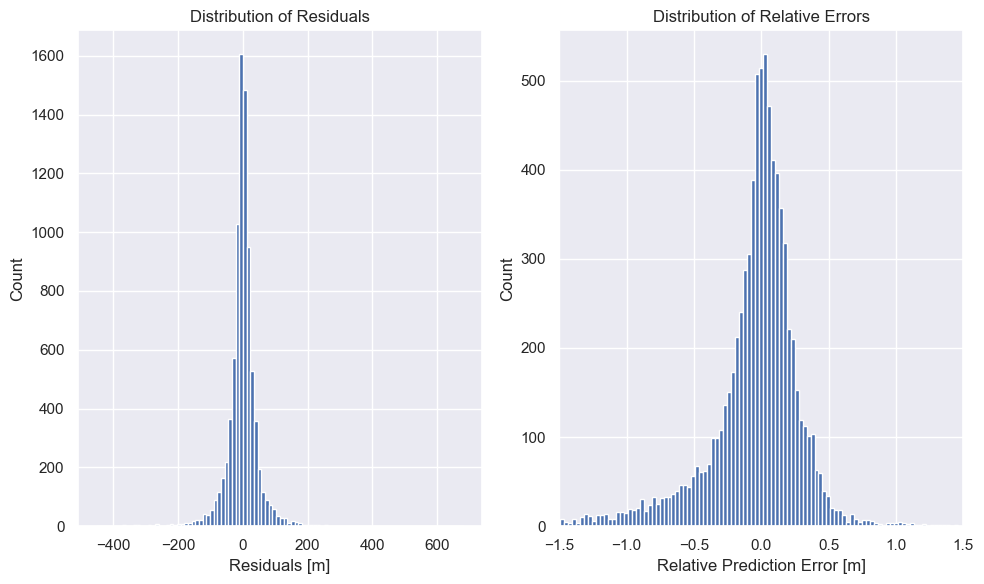

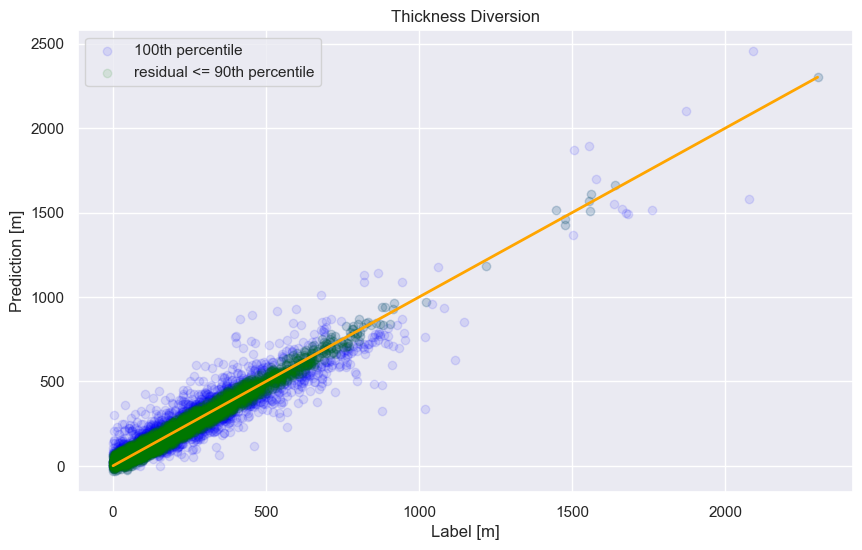

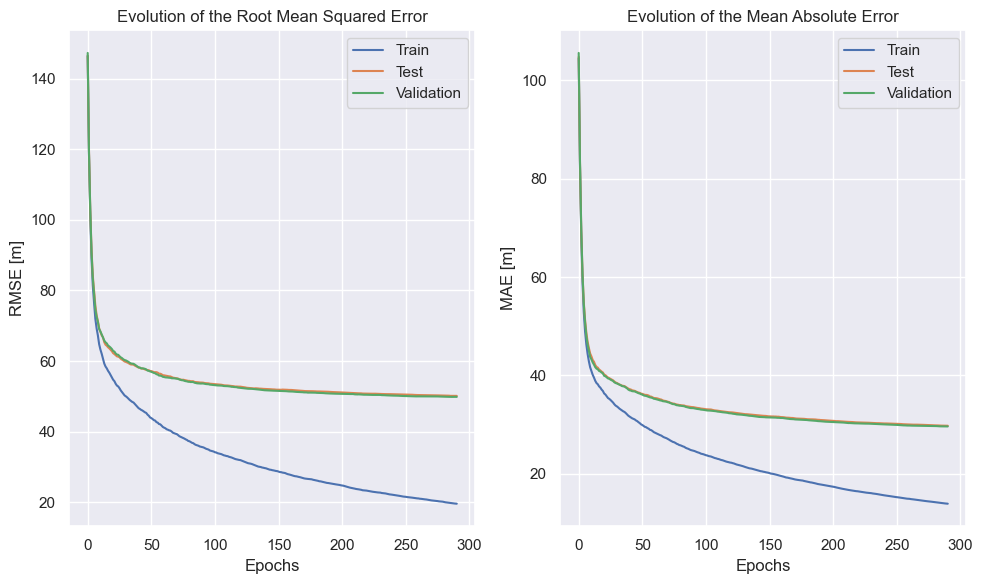

In [73]:
# plot evaluation
evaluation_plot(model, y_test, y_pred)

### Hyperparameter Optimization with Optuna

In [74]:
# Define the objective function for Optuna
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'n_estimators': 2000,
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'alpha': trial.suggest_float('alpha', 0, 1),
        'lambda': trial.suggest_float('lambda', 1, 10),
        'random_state': 42
    }
    
    model = xgb.XGBRegressor(**params, eval_metric=["mae", "rmse"], early_stopping_rounds=5)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    
    y_pred = model.predict(X_valid)
    mae = mean_absolute_error(y_valid, y_pred)
    return mae

# Create Optuna study and optimize
start_time = time.time()
study = optuna.create_study(direction='minimize')
n_trials = 50
study.optimize(objective, n_trials=n_trials)
end_time = time.time()
training_time_optuna = end_time - start_time


# Print the best hyperparameters
print(f"Best hyperparameters: {study.best_params}")

[I 2024-06-11 07:41:31,791] A new study created in memory with name: no-name-d23e81a0-5114-460c-a91b-badca0d62352
[I 2024-06-11 07:41:46,977] Trial 0 finished with value: 24.910862960491386 and parameters: {'max_depth': 9, 'learning_rate': 0.05715798371508972, 'min_child_weight': 4, 'subsample': 0.6294214919883107, 'gamma': 0.3103730164732321, 'alpha': 0.7774333682683775, 'lambda': 3.725857500326266}. Best is trial 0 with value: 24.910862960491386.
[I 2024-06-11 07:41:49,648] Trial 1 finished with value: 33.03083139465724 and parameters: {'max_depth': 5, 'learning_rate': 0.15376704546885628, 'min_child_weight': 10, 'subsample': 0.6115402670559104, 'gamma': 4.080998952406528, 'alpha': 0.9403032134964229, 'lambda': 5.540722174825259}. Best is trial 0 with value: 24.910862960491386.
[I 2024-06-11 07:41:59,253] Trial 2 finished with value: 42.868852795186086 and parameters: {'max_depth': 3, 'learning_rate': 0.011753784870548534, 'min_child_weight': 4, 'subsample': 0.5331705933748387, 'gamm

Best hyperparameters: {'max_depth': 10, 'learning_rate': 0.036952731667201845, 'min_child_weight': 1, 'subsample': 0.5064779729107524, 'gamma': 3.934432256529728, 'alpha': 0.2625262833953168, 'lambda': 7.782702553242691}


In [75]:
# print training time of optuna hyperparameter optimization
print(f"Optuna Optimization time: {training_time_optuna:.2f} seconds")

Optuna Optimization time: 1844.50 seconds


In [76]:
# train the final model with the best hyperparameters
best_params = study.best_params
start_time = time.time()
best_model = xgb.XGBRegressor(**best_params, objective='reg:squarederror', n_estimators=5000, 
                             eval_metric=["mae", "rmse"], random_state=42)
best_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test), (X_valid, y_valid)], early_stopping_rounds=5)
end_time = time.time()
training_time_best = end_time - start_time

y_pred_best = best_model.predict(X_test)

[0]	validation_0-mae:132.92742	validation_0-rmse:182.47886	validation_1-mae:133.24757	validation_1-rmse:182.89035	validation_2-mae:134.23594	validation_2-rmse:184.90914


C:\Users\luisa\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-mae:128.76132	validation_0-rmse:177.41820	validation_1-mae:129.21430	validation_1-rmse:177.89542	validation_2-mae:130.14709	validation_2-rmse:179.82510
[2]	validation_0-mae:124.75420	validation_0-rmse:172.61388	validation_1-mae:125.31435	validation_1-rmse:173.14617	validation_2-mae:126.20689	validation_2-rmse:175.02914
[3]	validation_0-mae:120.87408	validation_0-rmse:168.00720	validation_1-mae:121.51769	validation_1-rmse:168.56320	validation_2-mae:122.37210	validation_2-rmse:170.37411
[4]	validation_0-mae:117.18427	validation_0-rmse:163.51225	validation_1-mae:117.90973	validation_1-rmse:164.12705	validation_2-mae:118.72633	validation_2-rmse:165.85552
[5]	validation_0-mae:113.63615	validation_0-rmse:159.21703	validation_1-mae:114.43771	validation_1-rmse:159.84671	validation_2-mae:115.22795	validation_2-rmse:161.53198
[6]	validation_0-mae:110.20735	validation_0-rmse:155.23200	validation_1-mae:111.12066	validation_1-rmse:155.86627	validation_2-mae:111.87796	validation_2-r

In [77]:
# evaluate the regression
print(f"Training time: {training_time_best:.2f} seconds")
evaluate_regression(best_model, X_train, y_train, y_test, y_pred_best, k=5)
test_overfitting(best_model, mean_absolute_error, X_train, y_train, X_test, y_test, X_valid, y_valid)

Training time: 93.05 seconds
Mean Absolute Error: 23.241427269841946
Mean Squared Error: 1819.1520763846306
Root Mean Squared Error: 42.651519039591435
R-squared Score: 0.948516354448694
Median Absolute Error: 11.179015056903552
Mean Absolute Error on Relative Estimate Accuracy: 0.4003108970696176
Cross-Validation: 23.9170 +- 0.1681
Training Accuracy: 2.9272
Test Accuracy: 23.2414
Valid Accuracy: 23.1667


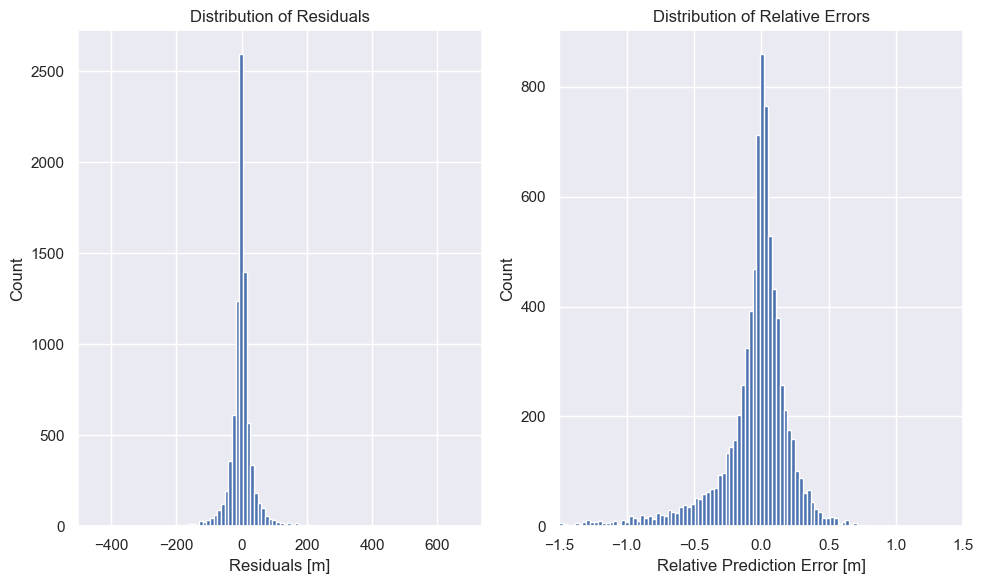

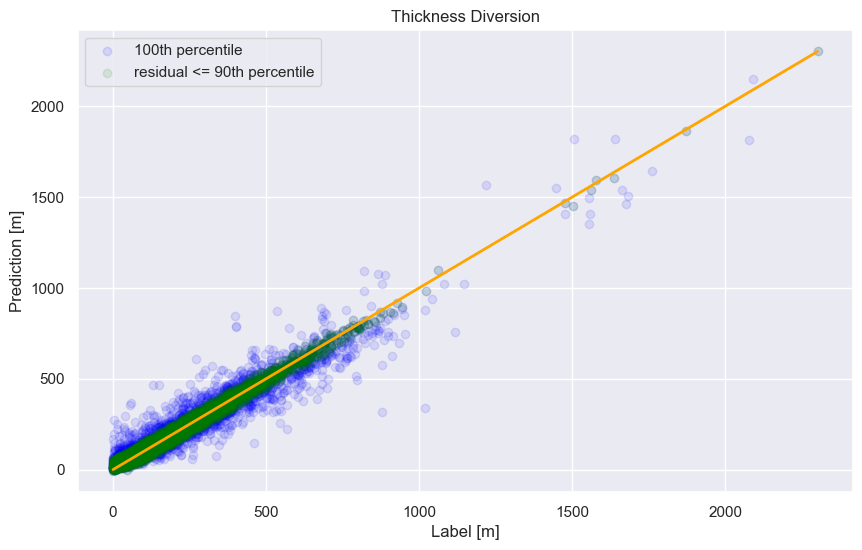

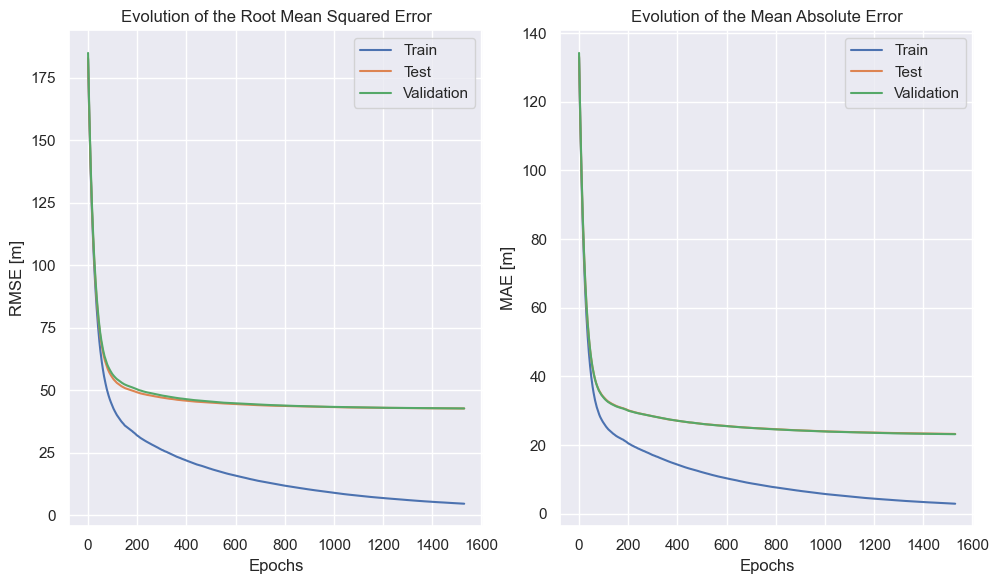

In [78]:
# plot evaluation
evaluation_plot(best_model, y_test, y_pred_best)